# Figure 4 supplementary: regression analysis for LP and PY

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
import torch
import time
from copy import deepcopy
import sys
sys.path.append("../../../setup")
sys.path.append("../../../simulator")
sys.path.append("../../../inference")
sys.path.append("../../../utils")
sys.path.append("../model/")
sys.path.append('../../')

from common import col, svg, samples_nd
import netio
import viz
import importlib
from compare_samples import get_dist, evaluate_summ_stats
from find_pyloric import merge_samples, params_are_bounded
import dill as pickle
from find_pyloric import merge_datasets, merge_datasets_energy, find_pyloric_like, find_close_to_obs
from energy import select_ss_close_to_obs

import matplotlib as mpl

from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net

In [3]:
from helper_functions import prepare_data, regression_plot, get_gradient

In [4]:
PANEL_A  = '../svg/panel_supp_a.svg'
PANEL_B1 = '../svg/panel_supp_b1.svg'
PANEL_B2 = '../svg/panel_supp_b2.svg'
PANEL_C1 = '../svg/panel_supp_c1.svg'
PANEL_C2 = '../svg/panel_supp_c2.svg'

PANEL_D  = '../svg/panel_supp_d.svg'
PANEL_E1 = '../svg/panel_supp_e1.svg'
PANEL_E2 = '../svg/panel_supp_e2.svg'
PANEL_F1 = '../svg/panel_supp_f1.svg'
PANEL_F2 = '../svg/panel_supp_f2.svg'

In [5]:
params_11 = netio.load_setup('collect_31D')
pyloric_sim_11 = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)

### Sort out the data from the cluster

In [6]:
outfile = '../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz'
data_n = np.load(outfile)
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]
print('There are', len(sample_seeds), 'datapoints in this dataset')

There are 55043 datapoints in this dataset


# Train regression net

### Prepare parameters

In [7]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

# LP neuron

### Prepare energy/spike

In [8]:
all_energies_per_spike_LP = sample_stats[:, 19]

In [9]:
numSpikesPerBurst_LP = sample_stats[:, -5] / sample_stats[:, -2]

### Prepare number of spikes / burst

In [10]:
(mean_energies_per_spike, 
std_energies_per_spike, 
train_energies_per_spike_norm,
test_energies_per_spike_norm,
mean_num_spikes,
std_num_spikes,
train_num_spikes_norm,
test_num_spikes_norm) = prepare_data(all_energies_per_spike_LP, numSpikesPerBurst_LP, num_test)

### Scatter spikes/burst against energy/spike

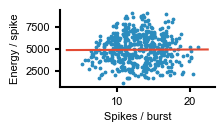

In [11]:
unnorm_x_vals, unnorm_y_regs, unnorm_x, unnorm_y = regression_plot(
    mean_energies_per_spike, 
    std_energies_per_spike, 
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm
)


with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.0))
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    ax.plot(unnorm_x_vals, unnorm_y_regs, '#e34a33')
    ax.set_xlabel('Spikes / burst')
    ax.set_ylabel('Energy / spike')
    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

### Train classifier

In [12]:
nn = classifier(dim=31)

In [13]:
# converged_nn = fit_regression_net(
#     nn, 
#     train_params_norm, 
#     train_energies_per_spike_norm, 
#     num_train=train_params_norm.shape[0],
#     batch_size=50, 
#     stop_after_epochs=10, 
#     max_epochs=200
# )

In [14]:
# np.savez('../../results/regression_nets/200821_predict_energyPerSpike_LP.npz', converged_nn=converged_nn)

In [15]:
data = np.load('../../results/regression_nets/200821_predict_energyPerSpike_LP.npz', allow_pickle=True)
converged_nn = data['converged_nn'].tolist()

In [16]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach().numpy()

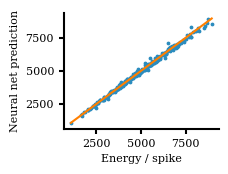

In [17]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_energies_per_spike_norm[:300] * std_energies_per_spike + mean_energies_per_spike
    unnorm_y = predictions[:300] * std_energies_per_spike + mean_energies_per_spike
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Energy / spike')
    ax.set_ylabel('Neural net prediction')
    #plt.savefig(PANEL_B1, facecolor='None', transparent=True)

### Get gradient wrt input

In [18]:
cum_grad = get_gradient(converged_nn, test_params_norm)

# Panel B: Sensitivity energy/spike

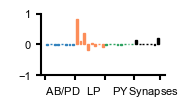

In [19]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1,1], figsize=(1.6, 0.8))
    plt.savefig(PANEL_B1, facecolor='None', transparent=True)
    plt.show()

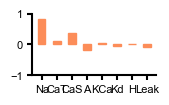

In [20]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1,1], start=8, end=16, figsize=(1.6, 0.8), color='#fc8d59')
    plt.savefig(PANEL_B2, facecolor='None', transparent=True)
    plt.show()

# Panel C: sensitivity number of spikes

In [21]:
nn = classifier(dim=31)

In [22]:
# converged_nn_num_spikes = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_num_spikes_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [23]:
# np.savez('../../results/regression_nets/200821_predict_numSpikes_LP.npz', converged_nn=converged_nn_num_spikes)

In [24]:
data = np.load('../../results/regression_nets/200821_predict_numSpikes_LP.npz', allow_pickle=True)
converged_nn_num_spikes = data['converged_nn'].tolist()

In [25]:
predictions = converged_nn_num_spikes.predict(torch.as_tensor(test_params_norm)).detach().numpy()

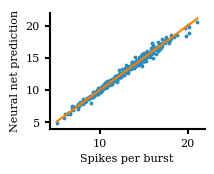

In [26]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_num_spikes_norm[:300] * std_num_spikes + mean_num_spikes
    unnorm_y = predictions[:300] * std_num_spikes + mean_num_spikes
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Spikes per burst')
    ax.set_ylabel('Neural net prediction')
    #plt.savefig(PANEL_supp2, facecolor='None', transparent=True)

### Get gradient wrt output

In [27]:
cum_grad = get_gradient(converged_nn_num_spikes, test_params_norm)

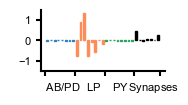

In [28]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1.5, 1.5], figsize=(1.6, 0.8))
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

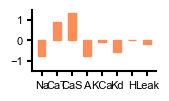

In [29]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1.5,1.5], start=8, end=16, figsize=(1.6, 0.8), color='#fc8d59')
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

# PY neuron

In [30]:
all_energies_per_spike_PY = sample_stats[:, 20]

In [31]:
numSpikesPerBurst_PY = sample_stats[:, -4] / sample_stats[:, -1]

In [32]:
(mean_energies_per_spike, 
std_energies_per_spike, 
train_energies_per_spike_norm,
test_energies_per_spike_norm,
mean_num_spikes,
std_num_spikes,
train_num_spikes_norm,
test_num_spikes_norm) = prepare_data(all_energies_per_spike_PY, numSpikesPerBurst_PY, num_test)

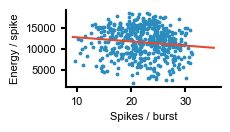

In [34]:
unnorm_x_vals, unnorm_y_regs, unnorm_x, unnorm_y = regression_plot(
    mean_energies_per_spike, 
    std_energies_per_spike, 
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm
)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.0))
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    ax.plot(unnorm_x_vals, unnorm_y_regs, '#e34a33')
    ax.set_xlabel('Spikes / burst')
    ax.set_ylabel('Energy / spike')
    plt.savefig(PANEL_D, facecolor='None', transparent=True)
    plt.show()

In [35]:
nn = classifier(dim=31)

In [36]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energies_per_spike_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200
)

Total number of trainable parameters 169001
Training loss   0.0016774101625409129
validation loss 0.0003614936751252899
Training loss   0.00045256442014157417
validation loss 0.00029227529864973373
Training loss   0.0003288580279103984
validation loss 0.00028585265676544743
Training loss   0.0002833388798357585
validation loss 0.0001859637534742668
Training loss   0.00025524692109221654
validation loss 0.00016349896875668513
Training loss   0.0002277507312286061
validation loss 0.00017359426196435795
Training loss   0.00021128473816435107
validation loss 0.0001474525629671668
Training loss   0.00019824145970665885
validation loss 0.00014590022378660036
Training loss   0.00018677004896090068
validation loss 0.00012387404424043613
Training loss   0.00017823965115934998
validation loss 0.00012469996457473877
Training loss   0.00017154336415543592
validation loss 0.00013595824829865279
Training loss   0.00016371368779193713
validation loss 0.000112570240866567
Training loss   0.00015917936

In [37]:
np.savez('../../results/regression_nets/200821_predict_energyPerSpike_PY.npz', converged_nn=converged_nn)

In [38]:
data = np.load('../../results/regression_nets/200821_predict_energyPerSpike_PY.npz', allow_pickle=True)
converged_nn = data['converged_nn'].tolist()

In [39]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach().numpy()

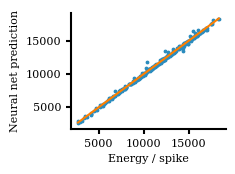

In [40]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_energies_per_spike_norm[:300] * std_energies_per_spike + mean_energies_per_spike
    unnorm_y = predictions[:300] * std_energies_per_spike + mean_energies_per_spike
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Energy / spike')
    ax.set_ylabel('Neural net prediction')
    #plt.savefig(PANEL_supp1, facecolor='None', transparent=True)

In [41]:
cum_grad = get_gradient(converged_nn, test_params_norm)

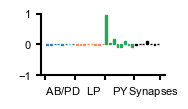

In [42]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1,1], figsize=(1.6, 0.8))
    plt.savefig(PANEL_E1, facecolor='None', transparent=True)
    plt.show()

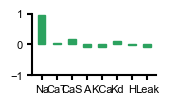

In [43]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1,1], start=16, end=24, figsize=(1.6, 0.8), color='#2ca25f')
    plt.savefig(PANEL_E2, facecolor='None', transparent=True)
    plt.show()

In [44]:
nn = classifier(dim=31)

In [45]:
converged_nn_num_spikes = fit_regression_net(
    nn,
    train_params_norm,
    train_num_spikes_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200
)

Total number of trainable parameters 169001
Training loss   0.0038939139611759216
validation loss 0.0009487219270929954
Training loss   0.0012657787797139592
validation loss 0.0005709065581944205
Training loss   0.0009043979433239493
validation loss 0.00048593594944471615
Training loss   0.0007757814768780718
validation loss 0.0004242739031530104
Training loss   0.0006943578731145399
validation loss 0.00043232365281728295
Training loss   0.0006740918994524226
validation loss 0.00042930622367439304
Training loss   0.0006094893486024399
validation loss 0.00040963131330026386
Training loss   0.0005930912897362334
validation loss 0.00033770443583086584
Training loss   0.0005630417651613091
validation loss 0.00035004045244043405
Training loss   0.0005496584179025262
validation loss 0.0004962132021265769
Training loss   0.0005281485925539976
validation loss 0.00032156125098589797
Training loss   0.0005263351188385811
validation loss 0.00048434461076854023
Training loss   0.000499628509008240

In [46]:
np.savez('../../results/regression_nets/200821_predict_numSpikes_PY.npz', converged_nn=converged_nn_num_spikes)

In [47]:
data = np.load('../../results/regression_nets/200821_predict_numSpikes_PY.npz', allow_pickle=True)
converged_nn_num_spikes = data['converged_nn'].tolist()

In [48]:
predictions = converged_nn_num_spikes.predict(torch.as_tensor(test_params_norm)).detach().numpy()

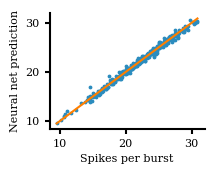

In [49]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_num_spikes_norm[:300] * std_num_spikes + mean_num_spikes
    unnorm_y = predictions[:300] * std_num_spikes + mean_num_spikes
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Spikes per burst')
    ax.set_ylabel('Neural net prediction')
    #plt.savefig(PANEL_supp2, facecolor='None', transparent=True)

In [50]:
cum_grad = get_gradient(converged_nn_num_spikes, test_params_norm)

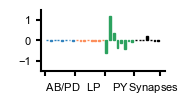

In [51]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1.5, 1.5], figsize=(1.6, 0.8))
    plt.savefig(PANEL_F1, facecolor='None', transparent=True)
    plt.show()

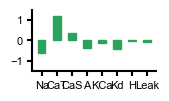

In [52]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1.5,1.5], start=16, end=24, figsize=(1.6, 0.8), color='#2ca25f')
    plt.savefig(PANEL_F2, facecolor='None', transparent=True)
    plt.show()

# Assembe figure

In [54]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [58]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

right_shift = 65
f = Figure("20.3cm", "7.9cm",

    Panel(
         SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 22.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(28*factor_svg, 22.0*factor_svg),
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(28*factor_svg, 39*factor_svg),
           
    Panel(
         SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
         Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move((2+right_shift)*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_E1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("e", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(right_shift*factor_svg, 22.0*factor_svg),
           
    Panel(
        SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move((28+right_shift)*factor_svg, 22.0*factor_svg),
    
    Panel(
          SVG(PANEL_F1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("f", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(right_shift*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_F2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move((28+right_shift)*factor_svg, 39*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_LP_PY.svg")
svg('../fig/fig4_supp_LP_PY.svg')

# Assemble figure

In [71]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [72]:
## from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "7.9cm",

    Panel(
         SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 22.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(28*factor_svg, 22.0*factor_svg),
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(28*factor_svg, 39*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4.svg")
svg('../fig/fig4.svg')

NameError: name 'Figure' is not defined